In [1]:
import numpy as np
import cv2
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
from tqdm import tqdm
import torch.nn as nn
sys.path.append("./Utils")
from utils import get_loaders, save_checkpoint, load_checkpoint, train_fn, save_predictions_as_imgs
sys.path.append('./Models')
from U_net import UNET
import torchvision

In [3]:
path_train = "../Data/dataset_DRIVE/training/images/"
training_images = os.listdir(path_train)

In [4]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

Text(0.5, 1.0, '21')

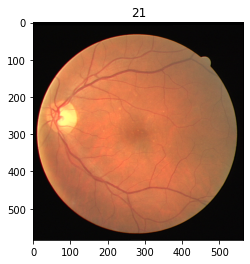

In [5]:
plt.imshow(train_images['21'])
plt.title('21')

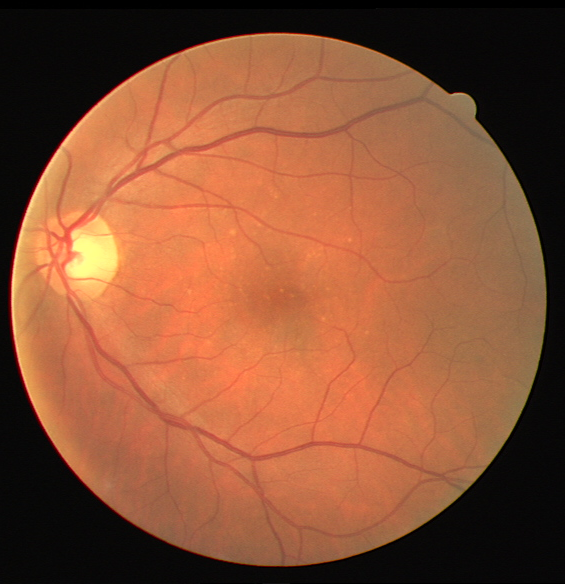

In [6]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

In [7]:
import torchvision.transforms.functional as TF

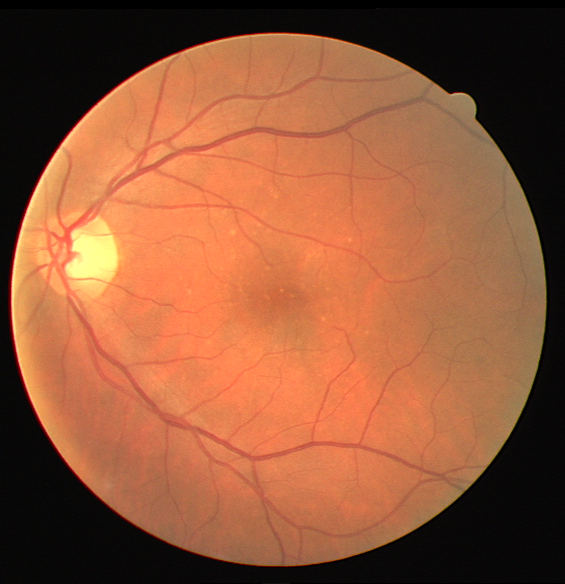

In [8]:
TF.adjust_brightness(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(0.5, 1.5))

In [9]:
#Procesado de los labels

In [10]:
path_labels = "../Data/dataset_DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

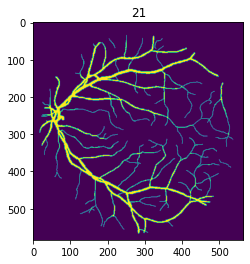

In [11]:
plt.imshow(labels['21'])
plt.title('21')

In [12]:
zeros = []
ones = []
for i in labels.keys():
    aux = labels[i]
    zeros.append(np.sum(aux==0).sum())
    ones.append(np.sum(aux==255).sum())

print(f"Avg_ratio: {np.mean(zeros)/np.mean(ones)}")

Avg_ratio: 10.49851677288112


Text(0.5, 1.0, '21')

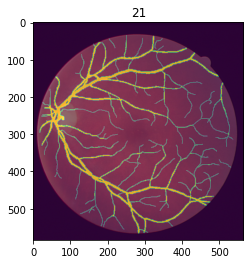

In [13]:
plt.imshow(labels['21'], alpha=1)
plt.imshow(train_images['21'], alpha=0.4)
plt.title('21')

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training Loader params

TRAIN_IMG_DIR = "../Data/dataset_DRIVE/training/images"
TRAIN_MASK_DIR = "../Data/dataset_DRIVE/training/1st_manual"
VAL_IMG_DIR = "../Data/dataset_DRIVE/validation/images"
VAL_MASK_DIR = "/../Data/dataset_DRIVE/validation/1st_manual"
RESIZE = None
BATCH_SIZE = 4
ROTATION = [-90, 90]
HFLIP_PROB = 0.5
BRIGHTNESS = [0.5, 1.5]
CONTRAST = [0.5, 1.5]
GAMMA = [0.5, 1.5]
NUM_WORKERS = 1
PIN_MEMORY = True

In [16]:
train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        RESIZE,
        ROTATION,
        HFLIP_PROB,
        BRIGHTNESS,
        CONTRAST,
        GAMMA,
        NUM_WORKERS,
        PIN_MEMORY)

Feature batch shape: torch.Size([4, 3, 584, 565])
Labels batch shape: torch.Size([4, 584, 565])
The Train image numbers present in the batch are: ('37', '30', '22', '33')


Text(0.5, 1.0, '37')

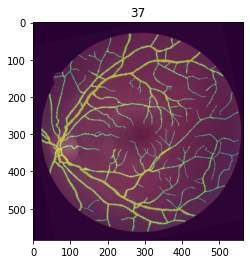

In [19]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

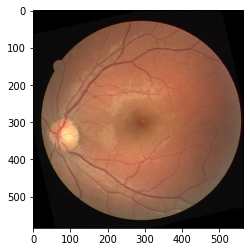

In [20]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

# Model 

In [21]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load("./Checkpoints/my_check.pth.tar", map_location=torch.device(DEVICE)),
    model)

 => Loading checkpoint 


In [ ]:
#save_predictions_as_imgs(val_loader, model, folder="./Checkpoints/images_predictions/", device=DEVICE)

In [ ]:
#Aquí se pintarían las gráficas

# Submission Grand Challenge

In [22]:
TEST_IMG_DIR = "../Data/dataset_DRIVE/test"

In [23]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import make_grid

In [24]:
test = ImageFolder(root=TEST_IMG_DIR, transform=transforms.ToTensor())

In [25]:
BATCH_SIZE = 4
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

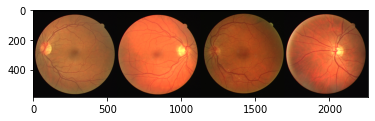

In [26]:
#First 4 test images
grid = make_grid(next(iter(test_loader))[0], nrow=4, padding=0, scale_each=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [37]:
# Predictions
folder = "../Data/dataset_DRIVE/submit"
model.eval()
number = list(range(1,5,1))
for x in test_loader:
    x = x[0].to(device=DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        for a,b in zip(preds,number):
            torchvision.utils.save_image(
            a, f"{folder}/{b}.png")
    number = [x + BATCH_SIZE for x in number]
